# Problem 21: Final exam, Fall 2020: The legacy of "redlining" #

> _Version 1.2 (Added clarification on regression part)_

This problem builds on your knowledge of the Python data stack to do analyze data that contains geographic information. It has **6** exercises, numbered 0 to **5**. There are **13 available points.** However, to earn 100%, the threshold is just **10 points.** (Therefore, once you hit **10** points, you can stop. There is no extra credit for exceeding this threshold.)

Each exercise builds logically on the previous one, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. **However, if you see a code cell introduced by the phrase, "Sample result for ...", please run it.** Some demo cells in the notebook may depend on these precomputed results.

The point values of individual exercises are as follows:

- Exercise 0: 2 points
- Exercise 1: 3 points
- Exercise 2: 2 points
- Exercise 3: 2 points
- Exercise 4: 2 points
- Exercise 5: 2 points

**Pro-tips.**
- All test cells use **randomly generated inputs.** Therefore, try your best to write solutions that do not assume too much. To help you debug, when a test cell does fail, it will often tell you exactly what inputs it was using and what output it expected, compared to yours.
- If you need a complex SQL query, remember that you can define one using a [triple-quoted (multiline) string](https://docs.python.org/3.7/tutorial/introduction.html#strings).
- If your program behavior seem strange, try resetting the kernel and rerunning everything.
- If you mess up this notebook or just want to start from scratch, save copies of all your partial responses and use `Actions` $\rightarrow$ `Reset Assignment` to get a fresh, original copy of this notebook. _(Resetting will wipe out any answers you've written so far, so be sure to stash those somewhere safe if you intend to keep or reuse them!)_
- If you generate excessive output (e.g., from an ill-placed `print` statement) that causes the notebook to load slowly or not at all, use `Actions` $\rightarrow$ `Clear Notebook Output` to get a clean copy. The clean copy will retain your code but remove any generated output. **However**, it will also **rename** the notebook to `clean.xxx.ipynb`. Since the autograder expects a notebook file with the original name, you'll need to rename the clean notebook accordingly.

**Good luck!**

## Background ##

During the economic Great Depression of the 1930s, the United States government began "rating" neighborhoods, on a letter-grade scale of "A" ("good") to "D" ("bad"). The purpose was to use such grades to determine which neighborhoods would qualify for new investments, in the form of residential and business loans.

But these grades also reflected racial and ethnic bias toward the residents of their neighborhoods. Nearly 100 years later, the effects have taken the form of environmental and economic disparaties.

In this notebook, you will get an idea of how such an analysis can come together using publicly available data and the basic computational data processing techniques that appeared in this course. (And after you finish the exam, we hope you will try the optional exercise at the end and refer to the "epilogue" for related reading.)

**Goal and workflow.** Your goal is to see if there is a relationship between the rating a neighborhood received in the 1930s and two attributes we can observe today: the average temperature of a neighborhood and the average home price.

- Temperature tells you something about the local environment. Areas with more parks, trees, and green space tend to experience more moderate temperatures.
- The average home price tells you something about the wealth or economic well-being of the neighborhood's residents.

Your workflow will consist of the following steps:

1. You'll start with neighborhood rating data, which was collected from public records as part of a [University of Richmond study on redlining policies](https://dsl.richmond.edu/panorama/redlining)
2. You'll then combine these data with satellite images, which give information about climate. These data come from the [US Geological Survey](https://usgs.gov/).
3. Lastly, you'll merge these data with home prices from the real estate website, [Zillow](https://zillow.com).

> Note: The analysis you will perform is correlational, but the deeper research that inspired this problem tries to control for a variety of factors and suggests causal effects.

## Part 0: Setup ##

At a minimum, you will need the following modules in this problem. They include a new one we did not cover called `geopandas`. While it may be new to you, if you have mastered `pandas`, then you know almost everything you need to use `geopandas`. Anything else you need will be given to you as part of this problem, so don't be intimidated!

In [1]:
import sys
print(f"* Python version: {sys.version}")

# Standard packages you know and love:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import geopandas
print("* geopandas version:", geopandas.__version__)

* Python version: 3.8.7 (default, Jan 25 2021, 11:14:52) 
[GCC 5.5.0 20171010]


Matplotlib is building the font cache; this may take a moment.


* geopandas version: 0.8.2


Run the next code cell, which will load some tools needed by the test cells.

In [2]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import data_fn, load_geopandas, load_df, load_pickle
from testing_tools import f_ex0__sample_result
from testing_tools import f_ex1__sample_result
from testing_tools import f_ex2__sample_result
from testing_tools import f_ex3__sample_result
from testing_tools import f_ex4__sample_result
from testing_tools import f_ex5__sample_result

## Part 1: Neighborhood ratings

The neighborhood rating data is stored in a special extension of a pandas `DataFrame` called a `GeoDataFrame`. Let's load the data into a variable named `neighborhood_ratings` and have a peek at the first few rows:

In [3]:
neighborhood_ratings = load_geopandas('fullDownload.geojson')
print(type(neighborhood_ratings))
neighborhood_ratings.head()

Opening geopandas data file, './resource/asnlib/publicdata/fullDownload.geojson' ...
<class 'geopandas.geodataframe.GeoDataFrame'>


,state,city,name,holc_id,holc_grade,area_description_data,geometry
0,AL,Birmingham,Mountain Brook Estates and Country Club Garden...,A1,A,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.75678 33.49754, -86.75692 ..."
1,AL,Birmingham,"Redmont Park, Rockridge Park, Warwick Manor, a...",A2,A,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.75867 33.50933, -86.76093 ..."
2,AL,Birmingham,"Colonial Hills, Pine Crest (outside city limits)",A3,A,"{'5': 'Generally speaking, houses are not buil...","MULTIPOLYGON (((-86.75678 33.49754, -86.75196 ..."
3,AL,Birmingham,"Grove Park, Hollywood, Mayfair, and Edgewood s...",B1,B,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.80111 33.48071, -86.80099 ..."
4,AL,Birmingham,Best section of Woodlawn Highlands,B10,B,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.74923 33.53332, -86.74916 ..."


Each row is a neighborhood. Its location is given by name, city, and a two-letter state abbreviation code (the `name`, `city`, and `state` columns, respectively). The rating assigned to a neighborhood is a letter, `'A'`, `'B'`, `'C'`, or `'D'`, given by the `holc_grade` column.

In addition, there is special column called `geometry`. It contains a geographic outline of the boundaries of this neighborhood. Let's take a look at row 4 (last row shown above):

* Type of `g4_example`: <class 'shapely.geometry.multipolygon.MultiPolygon'>

* Contents of `g4_example`: MULTIPOLYGON (((-86.749227 33.533325, -86.749156 33.530809, -86.75388599999999 33.529075, -86.754373 33.529382, -86.754729 33.529769, -86.754729 33.530294, -86.75604800000001 33.531225, -86.75539499999999 33.532008, -86.754456 33.532335, -86.753196 33.531483, -86.749714 33.533295, -86.749227 33.533325)))

* A quick visual preview:


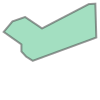

In [4]:
g4_example = neighborhood_ratings.loc[4, 'geometry']
print("* Type of `g4_example`:", type(g4_example))
print("\n* Contents of `g4_example`:", g4_example)
print("\n* A quick visual preview:")
display(g4_example)

The output indicates that this boundary is stored a special object type called a `MultiPolygon`. It is usually a single connected polygon, but may also be the union of multiple such polygons.

The coordinates of the multipolygon's corners are floating-point values, and correspond to [longitude and latitude values](https://www.latlong.net/). But for this notebook, the exact format won't be important. Simply treat the shapes as being specified in some way via a collection of two-dimensional $(x, y)$ coordinates measured in arbitrary units.

Lastly, observe that calling `display()` on a `MultiPolygon` renders a small picture of it.

### Exercise 0: Filtering ratings  (2 points) ###

Complete the function,
```python
def filter_ratings(ratings, city_st, targets=None):
    ...
```
so that it filters ratings data by its city and state name, along with a set of targeted letter grades. In particular, the inputs are:

- `ratings`: A geopandas `GeoDataFrame` similar to the `neighborhood_ratings` example above.
- `city_st`: The name of a city and two-letter state abbreviation as a string, e.g., `city_st = 'Atlanta, GA'` to request only rows for Atlanta, Georgia.
- `targets`: A Python set containing zero or more ratings, e.g., `targets = {'A', 'C'}` to request only rows having either an `'A'` grade or a `'C'` grade.

The function should return a copy of the input `GeoDataFrame` that has the same columns as `ratings` but only rows that match _both_ the desired `city_st` value _and_ any one of the target ratings.

For example, suppose `ratings` is the following:

|    | city        | state   | holc_grade   | holc_id   | _(... other cols not shown ...)_   | geometry          |
|---:|:------------|:--------|:-------------|:----------|:-----------------------|:------------------|
|  0 | Chattanooga | TN      | C            | C4        | ...                    | MULTIPOLYGON(...) |
|  1 | Augusta     | GA      | C            | C5        | ...                    | MULTIPOLYGON(...) |
|  2 | Chattanooga | TN      | B            | B7        | ...                    | MULTIPOLYGON(...) |
|  3 | Chattanooga | TN      | A            | A1        | ...                    | MULTIPOLYGON(...) |
|  4 | Augusta     | GA      | B            | B4        | ...                    | MULTIPOLYGON(...) |
|  5 | Augusta     | GA      | D            | D11       | ...                    | MULTIPOLYGON(...) |
|  6 | Augusta     | GA      | B            | B1        | ...                    | MULTIPOLYGON(...) |
|  7 | Chattanooga | TN      | D            | D8        | ...                    | MULTIPOLYGON(...) |
|  8 | Chattanooga | TN      | C            | C7        | ...                    | MULTIPOLYGON(...) |

Then `filter_ratings(ratings, 'Chattanooga, TN', {'A', 'C'})` would return

|    | city        | state   | holc_grade   | holc_id   | _(... other cols not shown ...)_   | geometry          |
|---:|:------------|:--------|:-------------|:----------|:-----------------------|:------------------|
|  0 | Chattanooga | TN      | C            | C4        | ...                    | MULTIPOLYGON(...) |
|  3 | Chattanooga | TN      | A            | A1        | ...                    | MULTIPOLYGON(...) |
|  8 | Chattanooga | TN      | C            | C7        | ...                    | MULTIPOLYGON(...) |

All of these rows match `'Chattanooga, TN'` and have a `holc_grade` value of either `'A'` or `'C'`. Other columns, such as `holc_id` and any columns not shown, would be returned as-is from the original input.

> **Note 0:** We will test your function on a randomly generated data frame. The input is guaranteed to have the columns, `'city'`, `'state'`, `'holc_grade'`, and `'geometry'`. However, it may have other columns with arbitrary names; your function should ensure these pass through unchanged, including the types.
>
> **Note 1:** Observe that `targets` may be `None`, which is the default value if unspecified by the caller. In this case, you should _not_ filter by rating, but only by `city_st`. The `targets` variable may be the empty set, in which case your function should return an empty `GeoDataFrame`.
>
> **Note 2:** You may return the rows in any order. We will use a function similar to `tibbles_are_equivalent` from Notebook 7 to determine if your output matches what we expect.

In [37]:
def filter_ratings(ratings, city_st, targets=None):
    assert isinstance(ratings, geopandas.GeoDataFrame)
    assert isinstance(targets, set) or (targets is None)
    assert {'city', 'state', 'holc_grade', 'geometry'} <= set(ratings.columns)

    city, state = city_st.split(', ')
    
    city_mask = (ratings['city'] == city) & (ratings['state'] == state)
    target_mask = ratings['holc_grade'].isin(targets) if targets is not None else True
    
    filtered_ratings = ratings.loc[city_mask & target_mask]

    return filtered_ratings


#     matches_city_st = (ratings['city'] + ', ' + ratings['state']) == city_st
#     matches_targets = ratings['holc_grade'].isin(targets or set()) | (targets is None)
#     return ratings[matches_city_st & matches_targets]

In [38]:
# Demo cell
ex0_demo_result = filter_ratings(neighborhood_ratings, 'Atlanta, GA', targets={'A', 'C'})
print(type(ex0_demo_result), len(ex0_demo_result)) # Result: `<class 'geopandas.geodataframe.GeoDataFrame'> 51`

ex0_demo_result.sample(5)

<class 'geopandas.geodataframe.GeoDataFrame'> 51


,state,city,name,holc_id,holc_grade,area_description_data,geometry
1342,GA,Atlanta,Older portion of West End,C35,C,"{'0': 'Atlanta, Georgia', '5': 'Property, if a...","MULTIPOLYGON (((-84.41899 33.73891, -84.41903 ..."
1339,GA,Atlanta,Capitol View,C32,C,"{'0': 'Atlanta, Georgia', '5': 'Property, if a...","MULTIPOLYGON (((-84.40711 33.71916, -84.40713 ..."
1318,GA,Atlanta,"Hancock subdivision, Atkins Park, western edge...",C13,C,"{'0': 'Atlanta, Georgia', '5': 'Property if ac...","MULTIPOLYGON (((-84.33932 33.78501, -84.34324 ..."
1355,GA,Atlanta,Section between Ponce de Leon and Forrest Aves...,C9,C,"{'0': 'Atlanta, Georgia', '5': 'Property if ac...","MULTIPOLYGON (((-84.36451 33.76639, -84.36468 ..."
1315,GA,Atlanta,"North Boulevard, between Amsterdam Avenue and ...",C10,C,"{'0': 'Atlanta, Georgia', '5': 'Property if ac...","MULTIPOLYGON (((-84.36770 33.79936, -84.36745 ..."


In [39]:
# Test cell: f_ex0__filter_ratings (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex0__check
print("Testing...")
for trial in range(125):
    f_ex0__check(filter_ratings)

filter_ratings__passed = True
print("\n(Passed!)")

Testing...


/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodatafram

/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.8/site-packages/geopandas/geodatafram


(Passed!)


**Sample result of `filter_ratings` (Exercise 0) for Atlanta.** If you had a working solution to Exercise 0, then in principle you could use it to visualize these neighborhoods, color-coded by grade, as the following cell does for `'Atlanta, GA'`.

> **Run this cell even if you did not complete Exercise 0.**

Opening geopandas data file, './resource/asnlib/publicdata/atl.geojson' ...


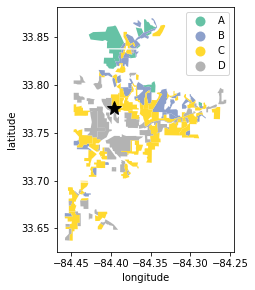

In [40]:
f_ex0__sample_result(); # The black "star" is Georgia Tech!

### Bounding boxes ###

Recall that a geopandas dataframe includes a `'geometry'` column, which defines the geographic shape of each neighborhood using special multipolygon objects. To simplify some geometric calculations, a useful operation is to determine a multipolygon's _bounding box_, which is the smallest rectangle that encloses it.

Getting a bounding box is easy! For example, recall the neighborhood in row 4 of the `neighborhood_ratings` geopandas dataframe:

* Type of `g4_example`: <class 'shapely.geometry.multipolygon.MultiPolygon'>

* Contents of `g4_example`: MULTIPOLYGON (((-86.749227 33.533325, -86.749156 33.530809, -86.75388599999999 33.529075, -86.754373 33.529382, -86.754729 33.529769, -86.754729 33.530294, -86.75604800000001 33.531225, -86.75539499999999 33.532008, -86.754456 33.532335, -86.753196 33.531483, -86.749714 33.533295, -86.749227 33.533325)))

* A quick visual preview:


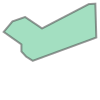

In [41]:
g4_example = neighborhood_ratings.loc[4, 'geometry']
print("* Type of `g4_example`:", type(g4_example))
print("\n* Contents of `g4_example`:", g4_example)
print("\n* A quick visual preview:")
display(g4_example)

The bounding box is given to you by the multipolygon's `.bounds` attribute. This attribute is a Python 4-tuple (tuple with four components) that encodes both the lower-left corner and the upper-right corner of the shape. Here is what that tuple looks like for the previous example:

In [42]:
print("* Recall: `g4_example` ==", g4_example)
print("\n* ==> `g4_example.bounds` ==", g4_example.bounds)

* Recall: `g4_example` == MULTIPOLYGON (((-86.749227 33.533325, -86.749156 33.530809, -86.75388599999999 33.529075, -86.754373 33.529382, -86.754729 33.529769, -86.754729 33.530294, -86.75604800000001 33.531225, -86.75539499999999 33.532008, -86.754456 33.532335, -86.753196 33.531483, -86.749714 33.533295, -86.749227 33.533325)))

* ==> `g4_example.bounds` == (-86.756048, 33.529075, -86.749156, 33.533325)


The first two elements of the tuple are the smallest possible x-value and the smallest possible y-value among all points of the multipolygon. The last two elements are the largest x-value and y-value.

If it's helpful, here is a plot that superimposes the bounding box on `g4_example`:

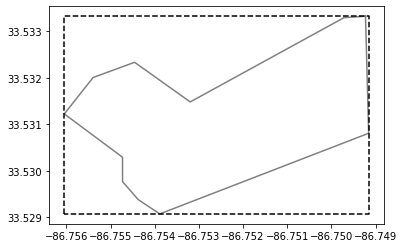

In [43]:
# Draw the multipolygon as a solid gray line:
from testing_tools import plot_multipolygon, plot_bounding_box
plot_multipolygon(g4_example, color='gray') 

# Add the bounding box as a dashed black line:
plot_bounding_box(g4_example.bounds, color='black', linestyle='--')

### Exercise 1: Bounding box of _all_ neighborhoods  (3 points) ###

Complete the function, `get_bounds(gdf)`, below, so that it returns the coordinates of a single bounding box for _all_ neighborhoods in a given dataframe.

For example, suppose `gdf_ex1_demo` holds rows 3 and 4 of the `neighborhood_ratings` dataframe:

In [44]:
gdf_ex1_demo = neighborhood_ratings.loc[[3, 4]]
gdf_ex1_demo

,state,city,name,holc_id,holc_grade,area_description_data,geometry
3,AL,Birmingham,"Grove Park, Hollywood, Mayfair, and Edgewood s...",B1,B,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.80111 33.48071, -86.80099 ..."
4,AL,Birmingham,Best section of Woodlawn Highlands,B10,B,{'5': 'Both sales and rental prices in 1929 we...,"MULTIPOLYGON (((-86.74923 33.53332, -86.74916 ..."


This dataframe has these bounds for each of the two rows:

In [45]:
print(gdf_ex1_demo.loc[3, 'geometry'].bounds)
print(gdf_ex1_demo.loc[4, 'geometry'].bounds)

(-86.815458, 33.464794, -86.767064, 33.483678)
(-86.756048, 33.529075, -86.749156, 33.533325)


Therefore, the bounding box for `gdf_ex1_demo` is the smallest rectangle that covers both neighborhoods, or `(-86.815458, 33.464794, -86.749156, 33.533325)`. The next code cell illustrates the result.

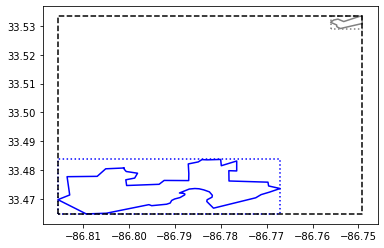

In [46]:
plot_multipolygon(gdf_ex1_demo.loc[3, 'geometry'], color='blue')
plot_bounding_box(gdf_ex1_demo.loc[3, 'geometry'].bounds, color='blue', linestyle=':')
plot_multipolygon(gdf_ex1_demo.loc[4, 'geometry'], color='gray')
plot_bounding_box(gdf_ex1_demo.loc[4, 'geometry'].bounds, color='gray', linestyle=':')

gdf_ex1_demo_bounding_box = (-86.815458, 33.464794, -86.749156, 33.533325)
plot_bounding_box(gdf_ex1_demo_bounding_box, color='black', linestyle='--')

The plot shows two multipolygons, along with the bounding box around each one as dotted lines. Your function should return a single bounding box for all multipolygons, which we show as the dashed black line that encloses both.

> **Note 0:** The test cell will use randomly generated input data frames. Per the example above, your solution should only depend on the presence of a column named `'geometry'`, and should return a correct result no matter what other columns are present in the input.
>
> **Note 1:** We've provided a partial solution that handles the corner-case of an empty input dataframe, so your solution can focus on dataframes having at least one row.

In [61]:
def get_bounds(gdf):
    assert isinstance(gdf, geopandas.GeoDataFrame)
    if len(gdf) == 0:
        return None
    assert len(gdf) >= 1
    
    x_min = y_min =float('inf')
    x_max = y_max =float('-inf')
    
    for _, row in gdf.iterrows():
        
        row_bounds = row['geometry'].bounds
        
        x_min = min(x_min, row_bounds[0])
        y_min = min(y_min, row_bounds[1])
        x_max = max(x_max, row_bounds[2])
        y_max = max(y_max, row_bounds[3])
    
    return (x_min, y_min, x_max, y_max)


#             (gdf['geometry'].apply(lambda x: x.bounds[0]).min(),
#             gdf['geometry'].apply(lambda x: x.bounds[1]).min(),
#             gdf['geometry'].apply(lambda x: x.bounds[2]).max(),
#             gdf['geometry'].apply(lambda x: x.bounds[3]).max())

In [62]:
# Demo cell
your_gdf_ex1_demo_bounding_box = get_bounds(gdf_ex1_demo)
print("Your result on the demo dataframe:", your_gdf_ex1_demo_bounding_box)
print("Expected result:", gdf_ex1_demo_bounding_box)

assert all([np.isclose(a, b) for a, b in zip(your_gdf_ex1_demo_bounding_box,
                                             gdf_ex1_demo_bounding_box)]), \
       "*** Your result does not match our example! ***"
print("Great -- so far, your result matches our expected result.")

Your result on the demo dataframe: (-86.815458, 33.464794, -86.749156, 33.533325)
Expected result: (-86.815458, 33.464794, -86.749156, 33.533325)
Great -- so far, your result matches our expected result.


In [63]:
# Test cell: f_ex1__get_bounds (3 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex1__check
print("Testing...")
for trial in range(250):
    f_ex1__check(get_bounds)

print("\n(Passed!)")

Testing...

(Passed!)


**Sample result of `get_bounds` (Exercise 1) for Atlanta.** If your function was working, then you could calculate the bounding box for Atlanta, which would be the following.

> **Run this cell even if you did not complete Exercise 1.**

Opening geopandas data file, './resource/asnlib/publicdata/atl.geojson' ...
Opening pickle from './resource/asnlib/publicdata/atl-bb.pickle' ...
Bounding box for Atlanta: (-84.457945, 33.637042, -84.254692, 33.869701)


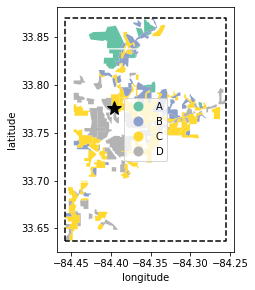

In [64]:
_, _, f_ex1__atl_bounds = f_ex1__sample_result();
print(f"Bounding box for Atlanta: {f_ex1__atl_bounds}")

## Part 2: Temperature analysis ##

We have downloaded satellite images that cover some of the cities in the `neighborhood_ratings` dataset. Each pixel of an image is the estimated temperature at the earth's surface. The images we downloaded were taken by the satellite on a summer day.

Here is an example of a satellite image that includes the Atlanta, Georgia neighborhoods used in earlier examples. The code cell below loads this image, draws it, and superimposes the Atlanta bounding box. The image is stored in the variable `sat_demo`. The geopandas dataframe for Atlanta is stored in `gdf_sat_demo`, and its bounding box in `bounds_sat_demo`.

Opening satellite image, './resource/asnlib/publicdata/LC08_CU_024013_20190808_20190822_C01_V01_ST--EPSG_4326.tif' ...
Opening geopandas data file, './resource/asnlib/publicdata/atl.geojson' ...
Opening pickle from './resource/asnlib/publicdata/atl-bb.pickle' ...


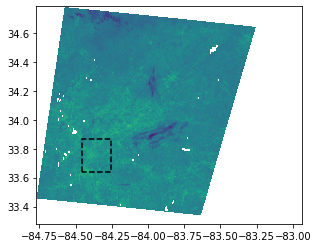

In [65]:
from testing_tools import load_satellite_image, plot_satellite_image

# Load a satellite image that includes the Atlanta area
sat_demo = load_satellite_image('LC08_CU_024013_20190808_20190822_C01_V01_ST--EPSG_4326.tif')

fig = plt.figure()
plot_satellite_image(sat_demo, ax=fig.gca())

# Add the bounding box for Atlanta
_, gdf_sat_demo, bounds_sat_demo = f_ex1__sample_result(do_plot=False);
plot_bounding_box(bounds_sat_demo, color='black', linestyle='dashed')

**Masked images:** _merging the satellite and neighborhood data._ A really cool feature of a geopandas dataframe is that you can "intersect" its polygons with an image!

We wrote a function called `mask_image_by_geodf(img, gdf)` that does this merging for you. It takes as input a satellite image, `img`, and a geopandas dataframe, `gdf`. It then clips the image to the bounding box of `gdf`, and masks out all the pixels. By "masking," we mean that pixels falling within the multipolygon regions of `gdf` retain their original value; everything outside those regions gets a special "undefined" value.

Here is an example. First, let's call `mask_image_by_geodf` to generate the Numpy array, stored as `sat_demo_masked`:

In [66]:
def mask_image_by_geodf(img, gdf):
    from json import loads
    from rasterio.mask import mask
    gdf_json = loads(gdf.to_json())
    gdf_coords = [f['geometry'] for f in gdf_json['features']]
    out_img, _ = mask(img, shapes=gdf_coords, crop=True)
    return out_img[0]
    
sat_demo_masked = mask_image_by_geodf(sat_demo, gdf_sat_demo)
print(sat_demo_masked.shape)
sat_demo_masked

(798, 698)


array([[-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999,  3167, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

The output shows the clipped result has a shape of 798 x 698 pixels, and the values are 16-bit integers (`dtype=int16`). The first thing you might see are a bunch of values equal to -9999. That is the special value indicating that the given pixel falls _outside_ of any neighborhood polygon.

Any other integer is the estimated surface temperature **in [degrees Kelvin](https://en.wikipedia.org/wiki/Kelvin#2019_redefinition) multiplied by 10**. For instance, suppose a pixel has the value `3167` embedded in the sample output above. That is 3167 / 10 = 316.7 degrees Kelvin, which in degrees Celsius would be 316.7 - 273.15 = 43.55 degrees Celsius. (That, in turn, is approximately (316.7 − 273.15) * 9/5 + 32 = 110.39 degrees Farenheit.)

In our analysis, we'd like to inspect the average temperatures of the neighborhoods, **ignoring** the -9999 values.

If it's helpful, here is a picture of that Numpy array. The dark regions correspond to the -9999 values that fall outside the neighborhoods of `gdf_sat_demo`; the bright ones indicate the presence of valid temperatures.

> If they appear to have the same color or shade, it's because the -9999 values make other "real" temperatures look nearly the same.

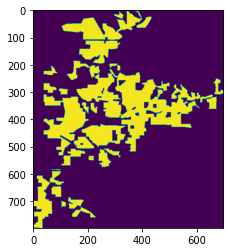

In [67]:
plt.imshow(sat_demo_masked)

### Exercise 2: Cleaning masked images (2 points) ###

To help our analysis, your next task is to clean a masked image, converting its values to degrees Celsius.

In particular, let `masked_array` be any Numpy array holding `int16` values, where the value `-9999` represents masked or missing values, and any other integer is a temperature in degrees Kelvin times 10. You should complete the function, `masked_to_degC(masked_array)`, so that it returns a _new_ Numpy array having the same shape as `masked_array`, but with the following properties:

- The new array should hold **floating-point** values, not integers. That is, the new Numpy array should have `dtype=float`.
- Every `-9999` value should be converted into a **not-a-number (NaN)** value.
- Any other integer value should be converted to **degrees Celsius.**

For instance, suppose `masked_array` is the following 2-D Numpy array:

```python
[[-9999  2950 -9999]
 [-9999  3167  2014]
 [-9999  3075  3222]
 [ 2801 -9999  2416]]
```

Then the output array should have the following values:

```python
[[   nan  21.85    nan]
 [   nan  43.55 -71.75]
 [   nan  34.35  49.05]
 [  6.95    nan -31.55]]
```

> **Note 0:** The simplest way to use a NaN value is through the predefined constant, [`np.nan`](https://numpy.org/doc/stable/user/misc.html).
>
> **Note 1:** There are three demo cells. Two of them show plots in addition to input/output pairs, in case you work better with visual representations. In the plots, any NaN entries will appear as blanks (white space).
>
> **Note 2:** Your function must work for an input array of _any_ dimension greater than or equal to 1. That is, it could be a 1-D array, a 2-D array (e.g., like true images), or 3-D or higher. Solutions that only work on 2-D arrays will only get half credit (one point instead of two).

In [70]:
# Note:
print(np.nan) # a single NaN value

nan


In [84]:
def masked_to_degC(masked_array):
    assert isinstance(masked_array, np.ndarray)
    assert masked_array.ndim >= 1
    assert np.issubdtype(masked_array.dtype, np.integer)
    
    new_masked_array = masked_array.copy()
    new_masked_array = new_masked_array.astype('float')
    
    new_masked_array[new_masked_array == -9999] = np.nan
    new_masked_array[new_masked_array != -9999] = (new_masked_array[new_masked_array != -9999]/10)-273.15
    
    return new_masked_array


#     new_array = masked_array.astype(float)
#     new_array[new_array == -9999] = np.nan
#     new_array *= 0.1
#     new_array -= 273.15

[[-9999  2950 -9999]
 [-9999  3167  2014]
 [-9999  3075  3222]
 [ 2801 -9999  2416]]

[[   nan  21.85    nan]
 [   nan  43.55 -71.75]
 [   nan  34.35  49.05]
 [  6.95    nan -31.55]]


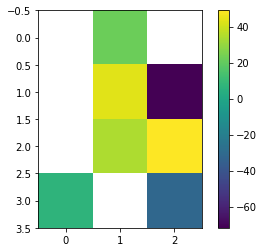

In [85]:
# Demo cell 0:
img_ex2_demo = np.array([[-9999,  2950, -9999],
                         [-9999,  3167, 2014],
                         [-9999,  3075, 3222],
                         [ 2801, -9999, 2416]], dtype=np.int16)

img_ex2_demo_clean = masked_to_degC(img_ex2_demo)

print(img_ex2_demo)
print()
print(img_ex2_demo_clean)
plt.imshow(img_ex2_demo_clean)
plt.colorbar();

In [86]:
# Demo cell 1: Try a 1-D array. Expected output: array([-260.85, nan, -227.55, -194.25, nan])
masked_to_degC(np.array([123, -9999, 456, 789, -9999], dtype=np.int16))

array([-260.85,     nan, -227.55, -194.25,     nan])

[[  nan   nan   nan ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]
 ...
 [  nan   nan 43.55 ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]]


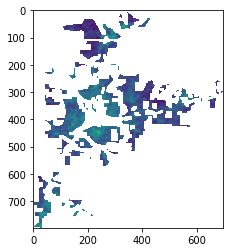

In [87]:
# Demo cell 2: Apply to the example satellite image
sat_demo_clean_ex2 = masked_to_degC(sat_demo_masked)
print(sat_demo_clean_ex2)
plt.imshow(sat_demo_clean_ex2);

In [88]:
# Test cell 0: f_ex2__masked_to_degC_2d (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex2__check
print("Testing...")
for trial in range(250):
    f_ex2__check(masked_to_degC, ndim=2)

masked_to_degC__passed_2d = True
print("\n(Passed the 2-D case!)")

Testing...

(Passed the 2-D case!)


In [89]:
# Test cell 1: f_ex2__masked_to_degC_nd (1 point)

from testing_tools import f_ex2__check
print("Testing...")
for trial in range(250):
    f_ex2__check(masked_to_degC, ndim=None)

print("\n(Passed the any-D case!)")

Testing...

(Passed the any-D case!)


**Sample result of `masked_to_degC` (Exercise 2) on the Atlanta data.** A correct implementation of `masked_to_degC` would, when applied to the Atlanta data, produce a masked image resembling what follows.

> **Run this cell even if you did not complete Exercise 2.**

Opening pickle from './resource/asnlib/publicdata/atl-masked-cleaned.pickle' ...


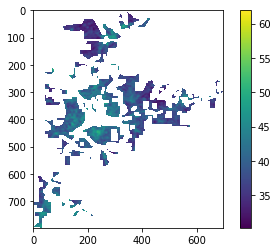

In [90]:
sat_demo_clean = f_ex2__sample_result();

### Exercise 3: Average temperature (2 points) ###

Suppose you are given `masked_array`, a Numpy array of masked floating-point temperatures like that _produced_ by `masked_to_degC` in Exercise 2. That is, it has floating-point temperature values _except_ at "masked" entries, which are marked by NaN values. Complete the function `mean_temperature(masked_array)` so that it returns the mean temperature value over all pixels, **ignoring any NaNs.**

For example, suppose `masked_array` equals the Numpy array,

```python
[[   nan  21.85    nan]
 [   nan  43.55 -71.75]
 [   nan  34.35  49.05]
 [  6.95    nan -31.55]]
```

where the values are in degrees Celsius. Then `mean_temperature(masked_array)` would equal (21.85+43.55-71.75+34.35+49.05+6.95-31.55)/7, which is approximately 7.49 degrees Celsius.

> **Note 0:** Your approach should work for an input array of _any_ dimension. You'll get partial credit (1 point) if it works for 2-D input arrays, and full credit (2 points) if it works for arrays of _all_ dimensions.
>
> **Note 1:** If all input values are NaN values, then your function should return NaN.

In [95]:
def mean_temperature(masked_array):
    assert isinstance(masked_array, np.ndarray)
    assert np.issubdtype(masked_array.dtype, np.floating)
    
    mean = np.nanmean(masked_array)
    
    return mean


In [96]:
# Demo cell 0:
img_ex3_demo_clean = np.array([[np.nan,  21.85, np.nan],
                               [np.nan,  43.55, -71.75],
                               [np.nan,  34.35,  49.05],
                               [  6.95, np.nan, -31.55]])
mean_temperature(img_ex3_demo_clean) # Expected result: ~ 7.49

7.492857142857143

In [97]:
# Demo cell 1: Check the 1-D case, as an example (expected output is roughly -277.55)
mean_temperature(np.array([-260.85, np.nan, -227.55, -194.25, np.nan]))

-227.55000000000004

In [98]:
# Demo cell 2: Mean temperature in Atlanta (a.k.a., "Hotlanta!")
mean_temperature(sat_demo_clean)

39.24372126540902

In [99]:
# Test cell 0: f_ex3__mean_temperature_2d (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex3__check
print("Testing...")
for trial in range(250):
    f_ex3__check(mean_temperature, ndim=2)

mean_temperature__passed_2d = True
print("\n(Passed the 2-D case!)")

Testing...

(Passed the 2-D case!)


<ipython-input-95-330645487524>:5: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(masked_array)


In [100]:
# Test cell 1: f_ex3__mean_temperature_nd (1 point)

from testing_tools import f_ex3__check
print("Testing...")
for trial in range(250):
    f_ex3__check(mean_temperature, ndim=None)

print("\n(Passed the N-D case!)")

Testing...

(Passed the N-D case!)


<ipython-input-95-330645487524>:5: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(masked_array)


**Sample result of `mean_temperature` (Exercise 3) for Atlanta.** If all of your code were working up until now, you could analyze the average temperature in each type of neighborhood by rating. You would see the result below. It shows that there is an observable difference in temperature based on the rating of the neighborhood -- a difference of 5 to 6 degrees Celsius is about 10 degrees Fahrenheit.

> **Run this cell even if you did not complete Exercise 3.**

In [101]:
f_ex3__sample_result();

Average temperatures in Atlanta during some summer day:
*  Overall: ~ 39.2 degrees Celsius (~ 102.6 deg F)
*  In 1930s 'A'-rated neighborhoods: ~ 35.3 degrees Celsius (~ 95.6 deg F)
*  In 1930s 'B'-rated neighborhoods: ~ 37.6 degrees Celsius (~ 99.7 deg F)
*  In 1930s 'C'-rated neighborhoods: ~ 39.3 degrees Celsius (~ 102.8 deg F)
*  In 1930s 'D'-rated neighborhoods: ~ 41.5 degrees Celsius (~ 106.7 deg F)


## Part 3: Real estate data ##

The last piece of data we'll incorporate is real estate data. Here is the raw data:

In [102]:
home_prices = load_df("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv") # From Zillow
print("\nColumns:\n", home_prices.columns, "\n")
home_prices.head(3)

Reading a regular pandas dataframe from './resource/asnlib/publicdata/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv' ...

Columns:
 Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '1996-01-31',
       ...
       '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
       '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31'],
      dtype='object', length=307) 



,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,223469.0,...,1152491.0,1129471.0,1101051.0,1088618.0,1078931.0,1075287.0,1072738.0,1072625.0,1075648.0,1073416.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,205864.0,...,476938.0,478070.0,479687.0,480848.0,481240.0,481907.0,483484.0,485902.0,489188.0,492585.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,227596.0,...,1105727.0,1118319.0,1118234.0,1126375.0,1129930.0,1132927.0,1133142.0,1136998.0,1149940.0,1152889.0


This dataframe has a lot of information, but here are the elements you need:

- Each row gives historical average home price estimates for different areas of the United States. The areas are uniquely identified by their 5-digit zip code, stored as integers in the `'RegionName'` column. Zip codes are areas that are _different_ from the neighborhoods you'd been considering previously.
- The city and two-letter state abbreviations are given by the `'City'` and `'State'` columns. Their values match the city and state abbreviations you've seen in the other data.
- The home price estimates appear in the columns given by numeric dates, in the string format `'yyyy-mm-dd'`.

### Exercise 4: Cleaning the dataframe (2 points) ###

Given a regular pandas dataframe `df` formatted like `home_prices` above, complete the function `clean_zip_prices(df)` so that it returns a new dataframe containing the following columns:

- `'ZipCode'`: The 5-digit zip code, taken from the `'RegionName'` column and stored as integers.
- `'City'`: The city name, taken directly from `'City'`.
- `'State'`: The two-letter state abbreviation, taken directly from `'State'`.
- `'Price'`: The home price, taken as the **latest** (most recent) date column and stored as floating-point values. In `home_prices`, the latest or most recent date is `'2020-10-31'`; therefore, the `'Price'` column of the output would contain the values from this column.

For example, suppose `df` is the following:

|    |   RegionID |   SizeRank |   RegionName | RegionType   | StateName   | State   | City            | Metro                    | CountyName         |   1996-01-31 |   2020-09-30 |   2020-10-31 |
|---:|-----------:|-----------:|-------------:|:-------------|:------------|:--------|:----------------|:-------------------------|:-------------------|-------------:|-------------:|-------------:|
|  0 |      98046 |       6533 |        95212 | Zip          | CA          | CA      | Stockton        | Stockton-Lodi            | San Joaquin County |          nan |       424606 |       430334 |
|  1 |      68147 |      16308 |        24445 | Zip          | VA          | VA      | Hot Springs     | nan                      | Bath County        |          nan |       138424 |       138496 |
|  2 |      84364 |       3748 |        60110 | Zip          | IL          | IL      | Carpentersville | Chicago-Naperville-Elgin | Kane County        |       138980 |       178311 |       179852 |

Then your function would return:

|    |   ZipCode | City            | State   |   Price   |
|---:|----------:|:----------------|:--------|----------:|
|  0 |     95212 | Stockton        | CA      |  430334.0 |
|  1 |     24445 | Hot Springs     | VA      |  138496.0 |
|  2 |     60110 | Carpentersville | IL      |  179852.0 |

> **Note 0:** We will test your code on randomly generated input dataframes. Therefore, your solution should only depend on the existence of the columns `'RegionName'`, `'City'`, `'State'`, and at least one column whose name is formatted as a date-string (`yyyy-mm-dd`). Any other columns may have different names from what is shown above and, in any case, are immaterial to your solution.
>
> **Note 1:** A helpful function for searching for column names matching a given pattern is [`df.filter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.filter.html).
>
> **Note 2:** Row ordering does not matter, since we will use an `tibbles_are_equivalent`-type function to check for dataframe equivalence.

In [177]:
def clean_zip_prices(df):
    assert isinstance(df, pd.DataFrame)
    
    import datetime
    
    columns = df.columns.tolist()
    filtered_col = df.filter(regex='^\d{4}-\d{2}-\d{2}$', axis=1)

    sorted_filtered_col = sorted(filtered_col, reverse=True)
    latest_date_col = sorted_filtered_col[0]
    
    new_df = df[[latest_date_col,'RegionName', 'City', 'State']].\
    rename(columns={'RegionName': 'ZipCode', latest_date_col: 'Price'})
    
    return new_df

#     last_date = sorted(df.filter(regex='\d{4}-\d{2}-\d{2}', axis=1).columns)[-1]
#     df_new = df[['RegionName', 'City', 'State', last_date]]
#     df_new = df_new.rename(columns={'RegionName': 'ZipCode', last_date: 'Price'})
#     df_new['ZipCode'] = df_new['ZipCode'].astype(int)
#     df_new['Price'] = df_new['Price'].astype(float)
#     return df_new



In [178]:
# Demo cell
clean_zip_prices(home_prices)

,Price,ZipCode,City,State
0,1073416.0,10025,New York,NY
1,492585.0,60657,Chicago,IL
2,1152889.0,10023,New York,NY
3,347871.0,77494,Katy,TX
4,629989.0,60614,Chicago,IL
...,...,...,...,...
30225,44241.0,47865,Carlisle,IN
30226,1343080.0,20052,Washington,DC
30227,30100.0,801,Charlotte Amalie,UT
30228,191183.0,820,Choudrant,LA


In [179]:
# Test cell: f_ex4__clean_zip_prices (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex4__check
print("Testing...")
for trial in range(250):
    f_ex4__check(clean_zip_prices)

print("\n(Passed!)")

Testing...

(Passed!)


**Sample result of `clean_zip_prices` (Exercise 4).** A successful implementation of Exercise 4 would produce a cleaned dataframe for `home_prices` as shown below.

> **Run this cell even if you did not complete Exercise 4.**

In [180]:
home_prices_clean = f_ex4__sample_result()
home_prices_clean.head()

Opening pickle from './resource/asnlib/publicdata/zip-prices.pickle' ...


,ZipCode,City,State,Price
0,10025,New York,NY,1073416.0
1,60657,Chicago,IL,492585.0
2,10023,New York,NY,1152889.0
3,77494,Katy,TX,347871.0
4,60614,Chicago,IL,629989.0


### Zip code boundaries ###

To merge the home prices with the neighborhood rating information, we need the geographic boundaries of the zip codes. The following code loads a geopandas dataframe with this information:

In [181]:
zip_geo = load_pickle('tl_2017_us_zcta510.pickle')
zip_geo.head(3)

Opening pickle from './resource/asnlib/publicdata/tl_2017_us_zcta510.pickle' ...


/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,GEOID10,geometry
0,43451,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,"POLYGON ((-83.08698 41.53780, -83.08256 41.537..."
2,43456,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."


This dataframe has just two columns: the zip code, stored as a **string** in the column named `'GEOID10'`, and `'geometry'`, which holds the shape of the zip code's area. Being stored in a geopandas dataframe, each zip code's boundary can be visualized easily and a bounding box computed, as the code cell below demonstrates.

> **Note 0:** Zip codes in this dataframe are stored as strings, rather than integers as in the pricing dataframe.
>
> **Note 1:** The sample zip code visualized by the following code cell is a bit unusual in that it consists of three spatially disconnected regions. However, that won't matter. Just note that each zip code is associated with some shape, just like the neighborhoods of the 1930s ratings data.

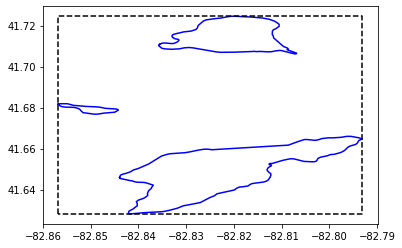

In [182]:
plot_multipolygon(zip_geo.loc[2, 'geometry'], color='blue')
plot_bounding_box(zip_geo.loc[2, 'geometry'].bounds, color='black', linestyle='dashed')

### Exercise 5 (last one!): Merging price and geographic boundaries (2 points) ###

Complete the function, `merge_prices_with_geo(prices_clean, zip_gdf)`, so that it merges price information stored in `prices_clean` with geographic boundaries stored in `zip_gdf`.

- The `prices_clean` object is a **pandas** dataframe that will have four columns, `'ZipCode'`, `'City'`, `'State'`, and `'Price'`, as would be produced by `clean_home_prices` (Exercise 4).
- The `zip_gdf` input is a **geopandas** dataframe with two columns, `'GEOID10'` and `'geometry'`.
- Your function should return a new **geopandas** dataframe with five columns: `'ZipCode'`, `'City'`, `'State'`, `'Price'`, and `'geometry'`.

> **Note 0:** Recall that the `'ZipCode'` column of `prices_clean` stores values as integers, whereas the `'GEOID10'` column of `zip_gdf` stores values as strings. In your final result, store the `'ZipCode'` column using integer values.
>
> **Note 1:** We are only interested in zip codes with _both_ price information _and_ known geographic boundaries. That is, if a zip code is missing in either `prices_clean` or `zip_gdf`, you should ignore and omit it from your output.
>
> **Note 2:** If `df` is a pandas dataframe, you can convert it to a geopandas one simply by calling `geopandas.GeoDataFrame(df)`.

In [201]:
def merge_prices_with_geo(prices_clean, zip_gdf):
    assert isinstance(prices_clean, pd.DataFrame)
    assert isinstance(zip_gdf, geopandas.GeoDataFrame)
    
    zip_gdf['GEOID10'] = zip_gdf['GEOID10'].apply(pd.to_numeric)
    
    prices_clean['ZipCode'] = prices_clean['ZipCode'].dropna()
    zip_gdf['GEOID10'] = zip_gdf['GEOID10'].dropna()
    
    df = prices_clean.merge(zip_gdf, left_on='ZipCode', right_on='GEOID10')
    
    df = df.drop(columns='GEOID10')
    
    return geopandas.GeoDataFrame(df)


    zip_gdf_int = zip_gdf.copy()
    zip_gdf_int['ZipCode'] = zip_gdf_int['GEOID10'].astype(int)
    prices_gdf = geopandas.GeoDataFrame(prices_clean)
    return prices_gdf.merge(zip_gdf_int[['ZipCode', 'geometry']], on='ZipCode')


In [202]:
# Demo cell
merge_prices_with_geo(home_prices_clean, zip_geo).head(3)

,ZipCode,City,State,Price,geometry
0,10025,New York,NY,1073416.0,"POLYGON ((-73.97701 40.79281, -73.97695 40.792..."
1,60657,Chicago,IL,492585.0,"POLYGON ((-87.67850 41.94504, -87.67802 41.945..."
2,10023,New York,NY,1152889.0,"POLYGON ((-73.99015 40.77231, -73.98992 40.773..."


In [203]:
merge_prices_with_geo(home_prices_clean, zip_geo).head(3)

,ZipCode,City,State,Price,geometry
0,10025,New York,NY,1073416.0,"POLYGON ((-73.97701 40.79281, -73.97695 40.792..."
1,60657,Chicago,IL,492585.0,"POLYGON ((-87.67850 41.94504, -87.67802 41.945..."
2,10023,New York,NY,1152889.0,"POLYGON ((-73.99015 40.77231, -73.98992 40.773..."


In [204]:
# Test cell: f_ex5__merge_prices_with_geo (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from testing_tools import f_ex5__check
print("Testing...")
for trial in range(250):
    f_ex5__check(merge_prices_with_geo)

print("\n(Passed!)")

Testing...

(Passed!)


## Part 4: Fin! (Epilogue and _optional_ wrap-up) ##

There are no additional required exercises — you’ve reached the end of the final exam and, therefore, of the class! Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. Good luck!

The code cells below provide a bit more supplementary information and analysis. If you've finished early and want to try an interesting analysis, give the optional "Exercise 6," below, a shot!

**Sample result of `merge_prices_with_geo` (Exercise 5).** One incredibly cool feature of geopandas is that it can do spatial (geographic) queries for you. For instance, let's merge the neighborhood rating data with the housing price data. The geopandas merging routines will account for how the geographic zones in one dataframe intersect with the other.

Visually, imagine laying the two "geographies" on top of one another, as illustrated below. (The shading corresponds with house prices by zip code regions, and the hollow polygons correspond to neighborhoods.)

![Overlaying neighborhoods and zip code boundaries](./resource/asnlib/public/real-estate-with-neighborhoods.png)

If a neighborhood overlaps with two zip codes, the merge can create two rows in the output for each combination of (neighborhood, zip code). That allows you to run subsequent queries, like examining the relationship between rating and price.

We have carried out this merge for you. Run the cell below to load that precomputed result into a geopandas dataframe named `neighborhood_prices` (as opposed to the original, `neighborhood_ratings`).

In [205]:
neighborhood_prices = f_ex5__sample_result()
neighborhood_prices.head()

Opening pickle from './resource/asnlib/publicdata/prices-geo.pickle' ...


/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,state,city,name,holc_id,holc_grade,area_description_data,ZipCode,Price,geometry
0,AL,Birmingham,Mountain Brook Estates and Country Club Garden...,A1,A,{'5': 'Both sales and rental prices in 1929 we...,35223,610462.0,"MULTIPOLYGON (((-86.76062 33.49298, -86.76202 ..."
1,AL,Birmingham,"Redmont Park, Rockridge Park, Warwick Manor, a...",A2,A,{'5': 'Both sales and rental prices in 1929 we...,35223,610462.0,"MULTIPOLYGON (((-86.77425 33.49538, -86.77430 ..."
2,AL,Birmingham,"Colonial Hills, Pine Crest (outside city limits)",A3,A,"{'5': 'Generally speaking, houses are not buil...",35223,610462.0,"POLYGON ((-86.75454 33.48883, -86.76227 33.488..."
3,AL,Birmingham,"Grove Park, Hollywood, Mayfair, and Edgewood s...",B1,B,{'5': 'Both sales and rental prices in 1929 we...,35223,610462.0,"MULTIPOLYGON (((-86.77070 33.47585, -86.76970 ..."
4,AL,Birmingham,First Addition to South Highlands,B3,B,{'5': 'Both sales and rental prices in 1929 we...,35223,610462.0,"POLYGON ((-86.77843 33.49367, -86.77847 33.490..."


If we consider just the Atlanta area, here is how today's average house price varies by that original 1930s neighborhood rating.

> This code cell requires a working solution to Exercise 0.

In [206]:
from testing_tools import f_ex5b__sample_result

if 'filter_ratings__passed' in globals() and filter_ratings__passed:
    f_ex5b__sample_result(neighborhood_prices, 'Atlanta, GA', filter_ratings) # Try other cities!
else:
    print("This code cell was not run because it needs a working version of `filter_ratings` from Exercise 0.")

Average house price in Atlanta, GA:
*  Overall: ~ $398,127.40
*  In 1930s 'A'-rated neighborhoods: ~ $589,818.12
*  In 1930s 'B'-rated neighborhoods: ~ $445,985.37
*  In 1930s 'C'-rated neighborhoods: ~ $393,349.46
*  In 1930s 'D'-rated neighborhoods: ~ $317,403.05


### OPTIONAL Exercise 6: Put it all together (no points) ###

We've provided satellite images for not just Atlanta, but all the cities defined in the dictionary below. Use all of your code from earlier exercises to repeat the Atlanta analysis for all other neighborhoods.

In particular, construct a table that shows, for each city, the percent differences in mean temperature and house price among the A/B/C/D-rated neighborhoods. Then try running a multiple regression (Notebook 12) to see how the 1930s rating predicts them.

> _Hint:_ To conduct the regression analysis, you'll want to "dummy-code" the ratings variable, since it is categorical (A, B, C, and D values). See [this explanation](https://stats.idre.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/#DUMMYCODING) if you aren't familiar with this practice. When you construct the data matrix, pandas's [`pd.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function is a good tool.

In [208]:
# Develop your analysis here!

# Merges neighborhood ratings, satellite image with temperatures, and Zillow data
# for a given city and (optionally) target rating. Returns the mean temperature
# and house price.
def merge_city(neighborhood_ratings, satimg, neighborhood_prices, city_st, targets=None):
    ratings = filter_ratings(neighborhood_ratings, city_st, targets)
    satimg_clean = mask_image_by_geodf(satimg, ratings)
    degC = mean_temperature(masked_to_degC(satimg_clean))
    prices = filter_ratings(neighborhood_prices, city_st, targets)
    price = prices['Price'].mean()
    return degC, price

# Merges data for every city having ratings, a temperature satellite image, and prices
def merge_all_data(ratings, images, prices):
    all_rows = []
    for city_st, satimg_filename in images.items():
        print(f"Processing {city_st} [image={satimg_filename}] ...")
        satimg = load_satellite_image(satimg_filename, verbose=False)
        degC_overall, price_overall = merge_city(ratings, satimg, prices, city_st)
        for rating in ['A', 'B', 'C', 'D']:
            degC_r, price_r = merge_city(ratings, satimg, prices, city_st, targets={rating})
            delta_degC = round(degC_r - degC_overall, 1)
            price_percent = round((price_r - price_overall) / price_overall * 100.0, 1)
            all_rows.append((city_st, rating, delta_degC, price_percent))
    return pd.DataFrame(all_rows, columns=['city_st', 'ratings', 'delta_degC', '%price'])

# Construct a data matrix from a table with a single categorical predictor
def build_matrix_dataframe(df, continuous=[], categorical=[], standardize=False, add_bias_term=False):
    df_data = df[continuous] if continuous else pd.DataFrame()
    if standardize:
        for col in continuous:
            mu = df[col].mean(skipna=True)
            df_data[col] = (df[col] - mu) / mu
    for col in categorical:
        df_cat_col = pd.get_dummies(df[col], prefix=col)
        df_data = pd.concat([df_data, df_cat_col], axis=0)
    if add_bias_term:
        df_data['__ones__'] = np.ones(len(df))
    return df_data

# ========== Analysis begins here ==========

# First, verify that dependent functions work:
if not ('filter_ratings__passed' in globals() and filter_ratings__passed \
        and 'mean_temperature__passed_2d' in globals() and mean_temperature__passed_2d \
        and 'masked_to_degC__passed_2d' in globals() and masked_to_degC__passed_2d \
        ):
    print("This code cell was not run because it needs working solutions from earlier exercises.")
    assert False, "*** Stopping execution here. ***"

summary_tibble = merge_all_data(neighborhood_ratings, satellite_image_data, neighborhood_prices)
summary_df = summary_tibble.pivot(index='city_st', values=['delta_degC', '%price'], columns=['ratings']).reset_index()
display(summary_df)

from numpy.linalg import lstsq
print(f"Regressing on neighborhood ratings {tuple(summary_tibble['ratings'].unique())}):")
X = build_matrix_dataframe(summary_tibble, categorical=['ratings']).values
for response in ['delta_degC', '%price']:
    y = summary_tibble[response]
    theta, _, _, _ = lstsq(X, y, rcond=None)
    print(f"* Response '{response}' has these weights: {theta.T}")
    


Processing Birmingham, AL [image=LC08_CU_022014_20200614_20200628_C01_V01_ST--EPSG_4326.tif] ...
Processing Los Angeles, CA [image=LC08_CU_003012_20200703_20200709_C01_V01_ST--EPSG_4326.tif] ...
Processing Denver, CO [image=LC08_CU_012009_20200812_20200824_C01_V01_ST--EPSG_4326.tif] ...
Processing New Haven, CT [image=LC08_CU_029006_20200613_20200627_C01_V01_ST--EPSG_4326.tif] ...
Processing Jacksonville, FL [image=LC08_CU_026016_20160709_20190430_C01_V01_ST--EPSG_4326.tif] ...
Processing Atlanta, GA [image=LC08_CU_024013_20190808_20190822_C01_V01_ST--EPSG_4326.tif] ...
Processing Chicago, IL [image=LC08_CU_021007_20160624_20181205_C01_V01_ST--EPSG_4326.tif] ...
Processing Indianapolis, IN [image=LC08_CU_022009_20200824_20200907_C01_V01_ST--EPSG_4326.tif] ...
Processing Louisville, KY [image=LC08_CU_023010_20200817_20200825_C01_V01_ST--EPSG_4326.tif] ...
Processing New Orleans, LA [image=LC08_CU_020016_20200612_20200627_C01_V01_ST--EPSG_4326.tif] ...
Processing Boston, MA [image=LC08_C

city_st delta_degC                %price                  
ratings                             A    B    C    D      A     B     C     D
0              Atlanta, GA       -3.9 -1.6  0.1  2.3   48.1  12.0  -1.2 -20.3
1            Baltimore, MD       -2.7 -1.2  1.2  2.8   11.1  10.6  -4.7 -14.8
2           Bergen Co., NJ       -2.9 -1.0  0.2  2.3   22.4   3.3  -1.1 -10.3
3           Birmingham, AL       -3.6  0.1  1.6 -0.2  166.6  52.9 -27.6 -35.2
4               Boston, MA       -5.4 -0.9 -0.2  2.3   17.9   3.4  -5.6   6.1
5             Brooklyn, NY       -0.0 -0.2 -0.2  0.3  -32.8  -4.9  -2.0   5.5
6           Charleston, WV       -2.8  0.6  1.1 -1.0   21.5  -3.6  -5.0   3.8
7            Charlotte, NC       -2.4 -0.6  0.5  1.1   38.5  27.2 -17.6  -7.4
8              Chicago, IL       -5.3 -1.9  0.8  0.8  103.7  23.7 -11.5 -24.1
9             Columbus, OH       -1.6 -0.1  0.3  0.8   27.5   5.5  -4.0 -10.9
10              Dallas, TX       -3.0 -1.1  1.0  1.9   57.8  -3.8 -20.1 -20.3
11              Denver, CO       11.6  1.5 -2.8  0.2   12.2  10.4  -0.5 -11.8
12             Detroit, MI       -3.0 -0.8  0.0  1.0   59.1  14.9  -1.4 -19.9
13        Indianapolis, IN       -1.7 -0.5 -0.3  1.2   15.5  -1.4  -3.2   1.1
14        Jacksonville, FL       -3.7 -0.6  0.1  0.9   32.5   7.7  -7.8 -10.0
15         Los Angeles, CA       -5.2 -0.8  1.2  1.1   40.5   7.9  -6.9 -22.2
16          Louisville, KY       -2.5 -0.4  0.3  1.9   46.7  10.0 -12.7 -15.3
17           Manhattan, NY       -1.0 -1.0  0.0  0.6    1.0 -12.3 -12.9   7.5
18       Milwaukee Co., WI       -2.9  0.4 -0.2  0.7   29.8  12.0  -5.4 -10.3
19         Minneapolis, MN       -2.8 -0.7  1.0  2.0    4.5   6.0  -4.7  -6.0
20           Nashville, TN       -2.2 -0.3 -0.2  1.3   20.7   5.3   0.5 -11.2
21           New Haven, CT       -3.2 -1.5  0.8  1.8    8.2  -1.5  -4.9   5.9
22         New Orleans, LA       -1.9 -0.7  0.2  0.2   16.6  13.7   2.0 -10.7
23        Philadelphia, PA       -4.4 -1.2  1.6  2.9   34.9   4.9 -15.0 -10.5
24            Portland, OR       -5.8  0.0  0.7  2.1   13.2   1.7  -7.8   7.6
25            Richmond, VA       -3.0 -0.3  0.2  1.6   18.9  11.8  -5.6 -20.7
26             Seattle, WA       -3.2 -0.6  1.0 -0.2    8.1   3.0  -1.0  -8.9
27            St.Louis, MO       -2.0  0.2  0.1  1.2   40.6 -11.2 -12.6 -14.2

Regressing on neighborhood ratings ('A', 'B', 'C', 'D')):
* Response 'delta_degC' has these weights: [-2.51785714 -0.54285714  0.36071429  1.21071429]
* Response '%price' has these weights: [31.61785714  7.47142857 -7.15357143 -9.91071429]


In [209]:
# Cities and their available satellite images
satellite_image_data = {
    'Birmingham, AL': 'LC08_CU_022014_20200614_20200628_C01_V01_ST--EPSG_4326.tif'
    , 'Los Angeles, CA': 'LC08_CU_003012_20200703_20200709_C01_V01_ST--EPSG_4326.tif'
    , 'Denver, CO': 'LC08_CU_012009_20200812_20200824_C01_V01_ST--EPSG_4326.tif' # incomplete
    , 'New Haven, CT': 'LC08_CU_029006_20200613_20200627_C01_V01_ST--EPSG_4326.tif' # incomplete
    , 'Jacksonville, FL': 'LC08_CU_026016_20160709_20190430_C01_V01_ST--EPSG_4326.tif' # mostly complete
    , 'Atlanta, GA': 'LC08_CU_024013_20190808_20190822_C01_V01_ST--EPSG_4326.tif'
    , 'Chicago, IL': 'LC08_CU_021007_20160624_20181205_C01_V01_ST--EPSG_4326.tif' # incomplete (multi-tile)
    , 'Indianapolis, IN': 'LC08_CU_022009_20200824_20200907_C01_V01_ST--EPSG_4326.tif'
    , 'Louisville, KY': 'LC08_CU_023010_20200817_20200825_C01_V01_ST--EPSG_4326.tif' # incomplete (multi-tile)
    , 'New Orleans, LA': 'LC08_CU_020016_20200612_20200627_C01_V01_ST--EPSG_4326.tif'
    , 'Boston, MA': 'LC08_CU_030006_20180719_20190614_C01_V01_ST--EPSG_4326.tif' # incomplete (multi-tile)
    , 'Baltimore, MD': 'LC08_CU_028008_20190812_20190822_C01_V01_ST--EPSG_4326.tif'  # mostly complete
    , 'Detroit, MI': 'LC08_CU_024007_20190714_20190723_C01_V01_ST--EPSG_4326.tif'  # mostly complete
    , 'Minneapolis, MN': 'LC08_CU_018005_20190613_20190621_C01_V01_ST--EPSG_4326.tif'
    , 'St.Louis, MO': 'LC08_CU_020010_20180723_20190614_C01_V01_ST--EPSG_4326.tif'
    , 'Charlotte, NC': 'LC08_CU_026012_20180823_20190614_C01_V01_ST--EPSG_4326.tif'
    , 'Bergen Co., NJ': 'LC08_CU_029007_20190830_20190919_C01_V01_ST--EPSG_4326.tif'
    , 'Manhattan, NY': 'LC08_CU_029007_20190830_20190919_C01_V01_ST--EPSG_4326.tif' # same tile as Bergen Co., NJ!
    , 'Brooklyn, NY': 'LC08_CU_029007_20190830_20190919_C01_V01_ST--EPSG_4326.tif' # same tile as Bergen Co., NJ!
    , 'Columbus, OH': 'LC08_CU_024009_20190824_20190908_C01_V01_ST--EPSG_4326.tif' # partial
    , 'Portland, OR': 'LE07_CU_003003_20190813_20190910_C01_V01_ST--EPSG_4326.tif'
    , 'Philadelphia, PA': 'LC08_CU_028008_20190720_20190803_C01_V01_ST--EPSG_4326.tif'
    , 'Nashville, TN': 'LC08_CU_022012_20190603_20190621_C01_V01_ST--EPSG_4326.tif'
    , 'Dallas, TX': 'LC08_CU_016014_20190816_20190906_C01_V01_ST--EPSG_4326.tif'
    , 'Richmond, VA': 'LC08_CU_027010_20190727_20190803_C01_V01_ST--EPSG_4326.tif'
    , 'Seattle, WA': 'LC08_CU_003002_20190828_20190905_C01_V01_ST--EPSG_4326.tif' # partial
    , 'Milwaukee Co., WI': 'LC08_CU_021007_20180801_20190614_C01_V01_ST--EPSG_4326.tif'
    , 'Charleston, WV': 'LC08_CU_025010_20190817_20190905_C01_V01_ST--EPSG_4326.tif'
}

**Epilogue.** The analysis in this notebook is inspired by a [New York Times article](https://www.nytimes.com/interactive/2019/08/09/climate/city-heat-islands.html) about the disproportionate affects of climate on different racial and socioeconomic groups. What you've done in this notebook just scratches the surface of that analysis, available in [this paper](https://www.mdpi.com/2225-1154/8/1/12/htm), but we hope you can appreciate how remarkable it is that with just a semester's worth of experience, this kind of data analysis is well within your grasp!

Indeed, although we ended up cutting it out of the problem, you could easily imagine applying any number of the analyses from Notebooks 12-15, starting with simple regression models that relate ratings with temperature and home prices.

Data sources for this notebook:
- Redlining data: The [_Mapping Inequality_ website](dsl.richmond.edu/panorama/redlining)
- Satellite data: The [US Geological Survey (USGS) Earth Explorer](https://earthexplorer.usgs.gov) (we used the "provisional land surface temperature" images)
- Real estate data: [Zillow Home Price Forecast Data for Researchers](https://www.zillow.com/research/data)
- Geographic boundaries for zip codes: [this blog post](https://n8henrie.com/uploads/2017/11/plotting-us-census-data-with-python-and-geopandas.html), which derives this information from US Census Data (see the post for details)